In [ ]:
!pip install optuna

In [ ]:
!pip install shap

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import lightgbm as lgb
from sklearn.preprocessing import LabelEncoder,MinMaxScaler, StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import optuna as opt
import shap

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [ ]:
df = pd.read_csv("/content/drive/MyDrive/projectDatabase/Employee.csv")
df.head()

,Education,JoiningYear,City,PaymentTier,Age,Gender,EverBenched,ExperienceInCurrentDomain,LeaveOrNot
0,Bachelors,2017,Bangalore,3,34,Male,No,0,0
1,Bachelors,2013,Pune,1,28,Female,No,3,1
2,Bachelors,2014,New Delhi,3,38,Female,No,2,0
3,Masters,2016,Bangalore,3,27,Male,No,5,1
4,Masters,2017,Pune,3,24,Male,Yes,2,1


Agora vamos fazer uma analise exploratoria dos dados

In [ ]:
fig=px.histogram(df,
                 x="Gender",
                 hover_data=df.columns,
                 title="Distribution of Gender")
fig.show()

In [ ]:
fig=px.histogram(df,
                 x="PaymentTier",
                 color="Gender",
                 hover_data=df.columns,
                 title="Distribution of Payment Tier",
                 barmode="stack")
fig.show()

In [ ]:
fig=px.histogram(df,
                 x="PaymentTier",
                 color="Education",
                 hover_data=df.columns,
                 title="Distribution of Education",
                 barmode="stack")
fig.show()

Probably the tier 3 is the lowest one, I thought it was the opposite. Interesting that they have more female than males in the tier 1, showing how they care about meritrocacy.

In [ ]:
fig=px.histogram(df,
                 x="City",
                 color="Gender",
                 hover_data=df.columns,
                 title="Distribution of City",
                 barmode="stack")
fig.show()

In [ ]:
df.dtypes

,0
Education,object
JoiningYear,int64
City,object
PaymentTier,int64
Age,int64
Gender,object
EverBenched,object
ExperienceInCurrentDomain,int64
LeaveOrNot,int64


I am going to transform the object columns into strings columns.

In [ ]:
colunas = df.select_dtypes("object").columns
df[colunas] = df[colunas].astype("string")
colunas = df.select_dtypes("object").columns

In [ ]:
df.dtypes

,0
Education,string[python]
JoiningYear,int64
City,string[python]
PaymentTier,int64
Age,int64
Gender,string[python]
EverBenched,string[python]
ExperienceInCurrentDomain,int64
LeaveOrNot,int64


In [ ]:
df.select_dtypes("string").columns.to_list()

['Education', 'City', 'Gender', 'EverBenched']

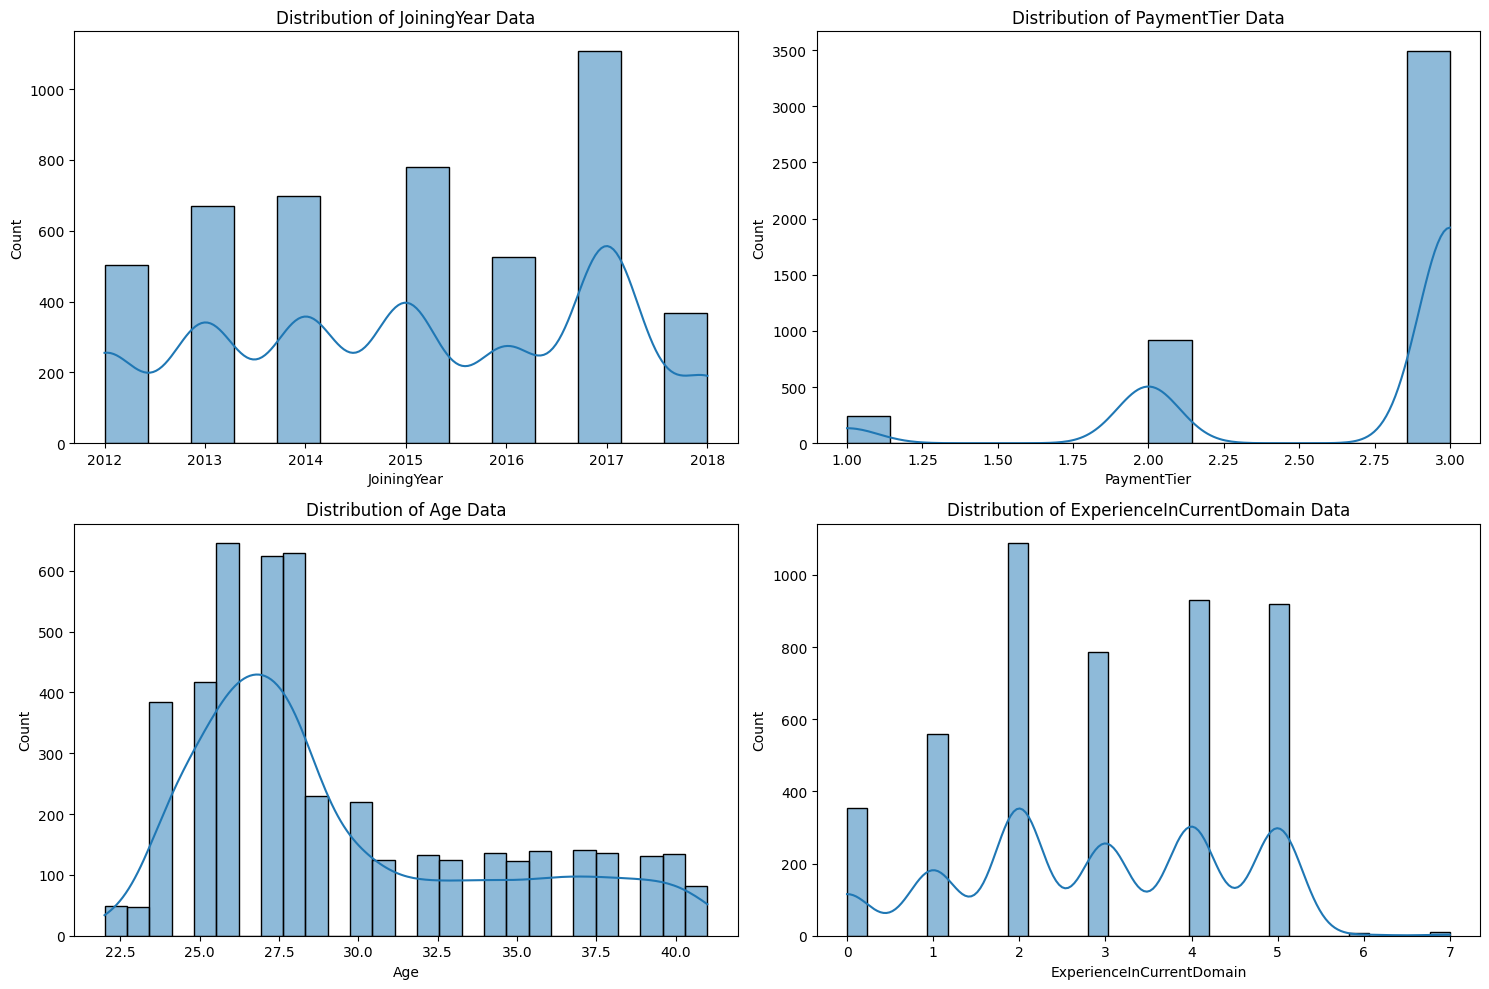

In [ ]:
string_col=df.select_dtypes("string").columns.to_list()
num_col=df.columns.to_list()


for col in string_col:
    num_col.remove(col)

num_col.remove("LeaveOrNot")
plt.figure(figsize=(15,10))
for i,col in enumerate(df.drop(['LeaveOrNot','Gender','Education', 'City', 'EverBenched'], axis=1).columns,1):
    plt.subplot(2,2,i)
    plt.title(f"Distribution of {col} Data")
    sns.histplot(df[col],kde=True)
    plt.tight_layout()
    plt.plot()

In [ ]:
df['EverBenchedBinary'] = df['EverBenched'].map({'No': 0, 'Yes': 1})
df['Male'] = df['Gender'].map({'Female': 0, 'Male': 1})
df.head()

,Education,JoiningYear,City,PaymentTier,Age,Gender,EverBenched,ExperienceInCurrentDomain,LeaveOrNot,EverBenchedBinary,Male
0,Bachelors,2017,Bangalore,3,34,Male,No,0,0,0,1
1,Bachelors,2013,Pune,1,28,Female,No,3,1,0,0
2,Bachelors,2014,New Delhi,3,38,Female,No,2,0,0,0
3,Masters,2016,Bangalore,3,27,Male,No,5,1,0,1
4,Masters,2017,Pune,3,24,Male,Yes,2,1,1,1


Considering this base was used in 2019...

In [ ]:
df['ExperienceInCompany'] = 2019 - df['JoiningYear']
df.head()

,Education,JoiningYear,City,PaymentTier,Age,Gender,EverBenched,ExperienceInCurrentDomain,LeaveOrNot,EverBenchedBinary,Male,ExperienceInCompany
0,Bachelors,2017,Bangalore,3,34,Male,No,0,0,0,1,2
1,Bachelors,2013,Pune,1,28,Female,No,3,1,0,0,6
2,Bachelors,2014,New Delhi,3,38,Female,No,2,0,0,0,5
3,Masters,2016,Bangalore,3,27,Male,No,5,1,0,1,3
4,Masters,2017,Pune,3,24,Male,Yes,2,1,1,1,2


In [ ]:
dum_col = pd.get_dummies(df[['Gender','Education', 'City']]).columns
df[dum_col] = pd.get_dummies(df[['Gender','Education', 'City']])
for col in dum_col:
    df[col] = df[col].map({True: 1, False: 0})
df.drop(['Gender','Education', 'City','EverBenched'], axis=1, inplace=True)
df.head()

,JoiningYear,PaymentTier,Age,ExperienceInCurrentDomain,LeaveOrNot,EverBenchedBinary,Male,ExperienceInCompany,Gender_Female,Gender_Male,Education_Bachelors,Education_Masters,Education_PHD,City_Bangalore,City_New Delhi,City_Pune
0,2017,3,34,0,0,0,1,2,0,1,1,0,0,1,0,0
1,2013,1,28,3,1,0,0,6,1,0,1,0,0,0,0,1
2,2014,3,38,2,0,0,0,5,1,0,1,0,0,0,1,0
3,2016,3,27,5,1,0,1,3,0,1,0,1,0,1,0,0
4,2017,3,24,2,1,1,1,2,0,1,0,1,0,0,0,1


In [ ]:
px.imshow(df.corr() , title="Correlation Plot of the Employees TurnOver Prediction")

In [ ]:
df.describe()

,JoiningYear,PaymentTier,Age,ExperienceInCurrentDomain,LeaveOrNot,EverBenchedBinary,Male,ExperienceInCompany,Gender_Female,Gender_Male,Education_Bachelors,Education_Masters,Education_PHD,City_Bangalore,City_New Delhi,City_Pune
count,4653.000000,4653.000000,4653.000000,4653.000000,4653.000000,4653.000000,4653.000000,4653.000000,4653.000000,4653.000000,4653.000000,4653.000000,4653.000000,4653.000000,4653.000000,4653.000000
mean,2015.062970,2.698259,29.393295,2.905652,0.343864,0.102729,0.597034,3.937030,0.402966,0.597034,0.773909,0.187621,0.038470,0.478831,0.248657,0.272512
std,1.863377,0.561435,4.826087,1.558240,0.475047,0.303638,0.490547,1.863377,0.490547,0.490547,0.418344,0.390451,0.192348,0.499605,0.432281,0.445300
min,2012.000000,1.000000,22.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2013.000000,3.000000,26.000000,2.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2015.000000,3.000000,28.000000,3.000000,0.000000,0.000000,1.000000,4.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2017.000000,3.000000,32.000000,4.000000,1.000000,0.000000,1.000000,6.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000
max,2018.000000,3.000000,41.000000,7.000000,1.000000,1.000000,1.000000,7.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
X = df.drop('LeaveOrNot', axis=1)
y = df['LeaveOrNot']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
lgb_model = lgb.LGBMClassifier(objective='binary', metric='auc', num_leaves=31, learning_rate=0.05, n_estimators=100)

In [ ]:
lgb_model.fit(X_train, y_train)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1124, number of negative: 2133
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000658 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 69
[LightGBM] [Info] Number of data points in the train set: 3257, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.345103 -> initscore=-0.640636
[LightGBM] [Info] Start training from score -0.640636


LGBMClassifier(learning_rate=0.05, metric='auc', objective='binary')

In [ ]:
y_pred = lgb_model.predict(X_test)

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

Accuracy: 0.8753581661891118
Precision: 0.8932291666666666
Recall: 0.7205882352941176
F1-score: 0.797674418604651


/usr/local/lib/python3.10/dist-packages/shap/explainers/_tree.py:448: UserWarning:

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray



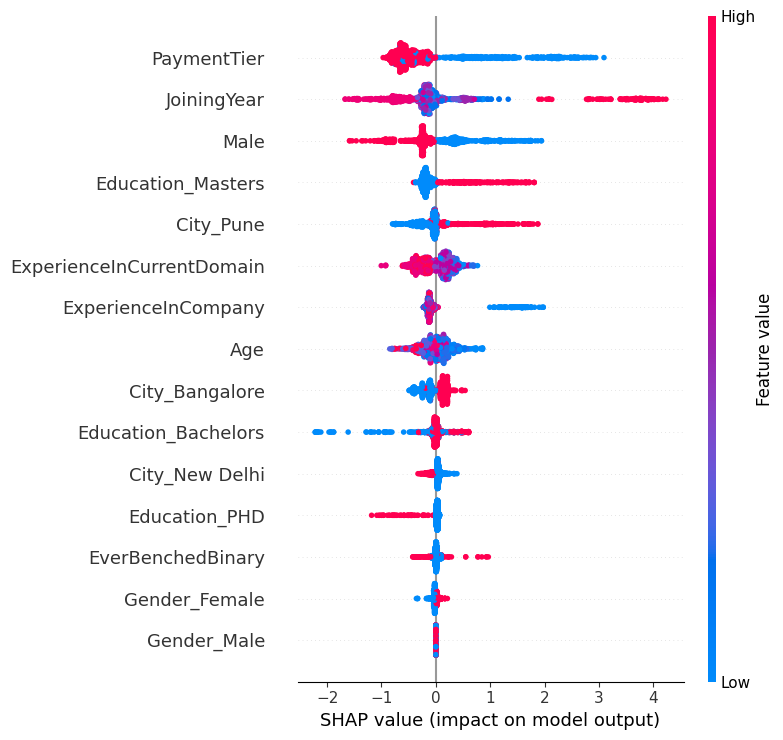

In [ ]:
explainer = shap.TreeExplainer(lgb_model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)

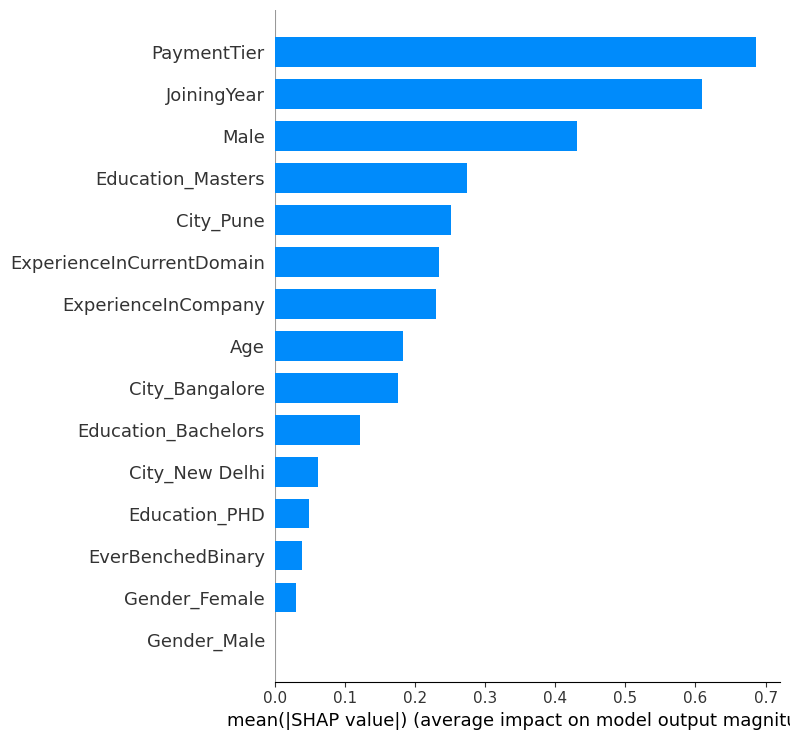

In [ ]:
shap.summary_plot(shap_values, X_test, plot_type='bar')

In [ ]:
if 'Prediction' in df.columns:
    df.drop('Prediction', axis=1, inplace=True)
df['Prediction'] = lgb_model.predict(df.drop('LeaveOrNot', axis=1))

In [ ]:
print("Total de Alertas: ", df[ df['Prediction'] == 1].count()['LeaveOrNot'])
print("Acertos: ", df[ df['Prediction'] == 1].sum()['LeaveOrNot'])

Total de Alertas:  1246
Acertos:  1115


In [ ]:
print("Alerta Negativo: ", df[ df['Prediction'] == 0].count()['LeaveOrNot'])
print("Falso negativo: ", df[ df['Prediction'] == 0].sum()['LeaveOrNot'])

Alerta Negativo:  3407
Falso negativo:  485


In [ ]:
print("Acertou: ", df[ df['Prediction'] == df['LeaveOrNot']].count()['LeaveOrNot'])
print("Errou: ", df[ df['Prediction'] != df['LeaveOrNot']].count()['LeaveOrNot'])
print("Percentual: ", df[ df['Prediction'] == df['LeaveOrNot']].count()['LeaveOrNot'] / df.count()['LeaveOrNot'])

Acertou:  4037
Errou:  616
Percentual:  0.8676122931442081
